# Generative Adversarial Networks 

In [1]:
__author__ = 'andrea munafo'

This notebook plays with GANs using the MNIST dataset.

Interesting references are reported at the end.

## GANs in brief

Suppose that we are interested in generating black and white square images of somthing (e.g. dogs) with a size of $nxn$ pixels.   
We can also reshape each image to be a vector of size $N=nxn$. This means that we can represent the image of a dog as a vector of size $N$.
This, of course, does not mean that all vectors of size $N$ represent dogs (once back to a square image) but we can say that the $N$ dimentional vectors that represent something that looks like a dog are distributed according to a very specific probability distribution over the entire $N$ dimensional vector space.
Some points of this space represent dogs, other might represent cats, etc.

The problem of generating a new image of dog is equivalent to the problem of generating a new vector according to the correct "dog probability distribution" [[1](https://towardsdatascience.com/understanding-generative-adversarial-networks-gans-cd6e4651a29)] over the $N$ dimensional vector space. 
This is the general problem of generating a random variable with respect to a specific probability distribution.

The problem then becomes that of using a neural network to approximate the target probability distribution.
This is equivalent to using the inverse transform sampling method using a neural network.

Our first problem when trying to generate our new image of dog is that the “dog probability distribution” over the N dimensional vector space is a very complex one and we don’t know how to directly generate complex random variables. However, as we know pretty well how to generate N uncorrelated uniform random variables, we could make use of the transform method. To do so, we need to express our N dimensional random variable as the result of a very complex function applied to a simple N dimensional random variable!
Here, we can emphasise the fact that finding the transform function is not as straightforward as just taking the closed-form inverse of the Cumulative Distribution Function (that we obviously don’t know) as we have done when describing the inverse transform method. The transform function can’t be explicitly expressed and, then, we have to learn it from data.

Then, the idea is to model the transform function using a neural network that takes as input a simple N dimensional uniform random variable and that returns as output another N dimensional random variable that should follow, after training, the right “dog probability distribution”.

To train this network we can use two methods. A direct one, where we compare the true and the generated probability distributions and then we backpropage the error. This is the idea behind Generative Matching Networks (GMNs).
In the indirect method we do not do a direct comparison but we add an additional layer (a discrimination task between true and generated samples) that somehow tries to enforce that the true and the generated distribution are as close as possible.
The indirect method is the one used by Generative Adversarial Networks.

So, in a GAN architecture, we have a discriminator, that takes samples of true and generated data and that try to classify them as well as possible, and a generator that is trained to fool the discriminator as much as possible.

## Implementing a simple GAN

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torch.autograd import Variable
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import os

import pylab as plt
import numpy as np

# from torch import nn

In [3]:
print(torch.__version__)

1.1.0


In [4]:
import pathlib

pathlib.Path("../results/08-generative-adversarial-networks").mkdir(parents=True, exist_ok=True)
pathlib.Path("../saved-mdls/08-generative-adversarial-networks").mkdir(parents=True, exist_ok=True)

In [5]:
num_epochs = 1
bs = 128
learning_rate = 0.0003

fake_img_size = 100

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [6]:
def toImg(x, mu=0.5, std=1):
    """Converts x to an image shape. It works for batches of inputs."""
    x = mu * (x + std)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

## Get the data

### Define some transforms to normalise the images  

In [7]:
ds_mean = 0.1307
ds_std = 0.3081

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
#    transforms.Normalize((ds_mean,), (ds_std,)) # The first tuple (0.5, 0.5, 0.5) is the mean for all three channels and the second (0.5, 0.5, 0.5) is the standard deviation for all three channels.
])

In [8]:
train_ds = MNIST('./data', train=True, transform=img_transform, download=True)
valid_ds = MNIST('./data', train=False, transform=img_transform, download=True)

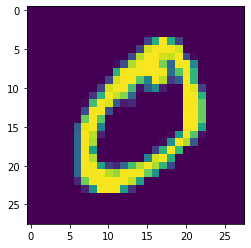

In [9]:
if torch.__version__ == '1.1.0':
    plt.imshow(train_ds.train_data.data[1])
else:
    plt.imshow(train_ds.data)

In [10]:
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=True)

## Define the model 

Let's create the two competing networks, the generator:

In [11]:
# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.generator = nn.Sequential(
            nn.Linear(fake_img_size, 256),
            nn.ReLU(True),
            nn.Linear(256, 256), 
            nn.ReLU(True), 
            nn.Linear(256, 784), 
            nn.Tanh())

    def forward(self, x):
        x = self.generator(x)
        return x
    

And the discriminator:

In [12]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Linear(784, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2), 
            nn.Linear(256, 1), 
            nn.Sigmoid())

    def forward(self, x):
        x = self.discriminator(x)
        return x
    

And now we put everything together:

In [14]:
Dnet = Discriminator()
Gnet = Generator()

if torch.cuda.is_available():
    Dnet = Dnet.cuda()
    Gnet = Gnet.cuda()
    
loss_fn = nn.BCELoss() # Binary cross entropy loss


# We need to optimizers, one per network.
d_optimizer = torch.optim.Adam(Dnet.parameters(), lr=learning_rate) #, momentum=0.9)
g_optimizer = torch.optim.Adam(Gnet.parameters(), lr=learning_rate) # , momentum=0.9)


## Train the model

In [16]:
def make_some_noise(bs, outsize):
    return torch.randn(bs, outsize)

In [17]:
num_epochs = 100

In [20]:
for epoch in range(num_epochs):
    for i, (x, y) in enumerate(train_dl): # x is the real image, y is the real label
        img_nums = x.shape[0] # effective batch size
                
        # In this case, we want to discriminate which one is real and which is fake.
        # So we create the labels accordingly.
        real_label = Variable(torch.ones(img_nums)).to(device)
        fake_label = Variable(torch.zeros(img_nums)).to(device)
        
        
        # Train the discriminator network on real data
        x = x.view(x.size(0), -1).to(device)
        x = Variable(x).to(device) # useless?
        
        # compute loss of real_img
        d_real_out = Dnet(x)
        d_loss_real = loss_fn(d_real_out.squeeze(), real_label) 
        real_scores = d_real_out  # closer to 1 means better
        
        # training discriminator on the data produced by generator
        # generate the image of a specific dimention (z_dimention).
        # We start from noise.
        z = Variable(torch.randn(img_nums, fake_img_size)).to(device)
        fake_x = Gnet(z).detach()
        d_fake_out = Dnet(fake_x)
        d_loss_fake = loss_fn(d_fake_out.squeeze(), fake_label)        
        

        fake_scores = d_fake_out  # closer to 0 means better

        # backprop
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()        
        
                
        
        # Train the generator network
        
        # compute loss of fake_img
        z = Variable(torch.randn(img_nums, fake_img_size)).to(device)
        fake_img = Gnet(z)
        output = Dnet(fake_img)
        g_loss = loss_fn(output, real_label) # not sure why I have real_label here!

        # We’ll then pass the output of generator to 
        # discriminator and see what discriminator has
        # to say about it. 
        # If discriminator predicts 1 for our generated data, 
        # well and good, the generator is working okay, and if discriminator predict 0, generator needs to still learn.
        
        # backprop and optimize
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
                        
        
        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], d_loss: {:.6f}, g_loss: {:.6f} '
                  'DISC Real img: {:.6f}, DISC fake img: {:.6f}'.format(
                  epoch, num_epochs, d_loss.data, g_loss.data,
                  real_scores.data.mean(), fake_scores.data.mean()))
        
        
    if epoch == 0:
        print('Epoch [{}/{}], saving a sample of real images.'.format(epoch, num_epochs))
        real_images = toImg(x.cpu().data)
        save_image(real_images, '../results/08-generative-adversarial-networks/real-images.png')
        

    fake_images = toImg(fake_img.cpu().data)
    save_image(fake_images, '../results/08-generative-adversarial-networks/fake-images-{}.png'.format(epoch + 1))

Epoch [0/100], d_loss: 0.424528, g_loss: 2.252787 DISC Real img: 0.881021, DISC fake img: 0.176782
Epoch [0/100], d_loss: 1.053300, g_loss: 1.894525 DISC Real img: 0.736698, DISC fake img: 0.263714
Epoch [0/100], d_loss: 0.295906, g_loss: 3.486203 DISC Real img: 0.907386, DISC fake img: 0.076886
Epoch [0/100], d_loss: 0.438196, g_loss: 3.213243 DISC Real img: 0.848169, DISC fake img: 0.076060
Epoch [0/100], saving a sample of real images.
Epoch [1/100], d_loss: 0.214261, g_loss: 3.936929 DISC Real img: 0.932659, DISC fake img: 0.043150
Epoch [1/100], d_loss: 0.299357, g_loss: 5.061038 DISC Real img: 0.909149, DISC fake img: 0.093833
Epoch [1/100], d_loss: 0.160245, g_loss: 4.774524 DISC Real img: 0.935502, DISC fake img: 0.042899
Epoch [1/100], d_loss: 0.200768, g_loss: 4.684272 DISC Real img: 0.923627, DISC fake img: 0.062076
Epoch [2/100], d_loss: 0.890395, g_loss: 2.721568 DISC Real img: 0.774522, DISC fake img: 0.192272
Epoch [2/100], d_loss: 0.411399, g_loss: 3.981195 DISC Real im

Epoch [20/100], d_loss: 0.439884, g_loss: 3.891703 DISC Real img: 0.846914, DISC fake img: 0.081569
Epoch [20/100], d_loss: 0.566535, g_loss: 4.469088 DISC Real img: 0.830451, DISC fake img: 0.107427
Epoch [21/100], d_loss: 0.224628, g_loss: 5.206778 DISC Real img: 0.937453, DISC fake img: 0.096075
Epoch [21/100], d_loss: 0.423582, g_loss: 3.508548 DISC Real img: 0.875578, DISC fake img: 0.115339
Epoch [21/100], d_loss: 0.437979, g_loss: 2.103335 DISC Real img: 0.880889, DISC fake img: 0.155936
Epoch [21/100], d_loss: 0.586760, g_loss: 2.661325 DISC Real img: 0.847386, DISC fake img: 0.147860
Epoch [22/100], d_loss: 0.483141, g_loss: 3.928711 DISC Real img: 0.834755, DISC fake img: 0.090883
Epoch [22/100], d_loss: 0.303190, g_loss: 3.988225 DISC Real img: 0.884667, DISC fake img: 0.088099
Epoch [22/100], d_loss: 0.510553, g_loss: 3.185476 DISC Real img: 0.809855, DISC fake img: 0.101547
Epoch [22/100], d_loss: 0.299616, g_loss: 4.596398 DISC Real img: 0.895371, DISC fake img: 0.085981


Epoch [41/100], d_loss: 0.674481, g_loss: 2.514789 DISC Real img: 0.759397, DISC fake img: 0.197681
Epoch [41/100], d_loss: 0.556177, g_loss: 2.967801 DISC Real img: 0.812357, DISC fake img: 0.146901
Epoch [41/100], d_loss: 0.684363, g_loss: 3.370574 DISC Real img: 0.744692, DISC fake img: 0.100284
Epoch [41/100], d_loss: 0.434879, g_loss: 2.943501 DISC Real img: 0.819179, DISC fake img: 0.120291
Epoch [42/100], d_loss: 0.352778, g_loss: 3.155353 DISC Real img: 0.882804, DISC fake img: 0.132586
Epoch [42/100], d_loss: 0.711110, g_loss: 2.593189 DISC Real img: 0.769609, DISC fake img: 0.149619
Epoch [42/100], d_loss: 0.585647, g_loss: 2.712711 DISC Real img: 0.824157, DISC fake img: 0.208452
Epoch [42/100], d_loss: 0.727605, g_loss: 2.393080 DISC Real img: 0.731138, DISC fake img: 0.101890
Epoch [43/100], d_loss: 0.605551, g_loss: 3.149654 DISC Real img: 0.788011, DISC fake img: 0.118324
Epoch [43/100], d_loss: 0.602683, g_loss: 2.717774 DISC Real img: 0.811976, DISC fake img: 0.174113


Epoch [65/100], d_loss: 0.694315, g_loss: 2.203867 DISC Real img: 0.746835, DISC fake img: 0.185899
Epoch [65/100], d_loss: 0.934770, g_loss: 1.657416 DISC Real img: 0.723196, DISC fake img: 0.280901
Epoch [65/100], d_loss: 0.640320, g_loss: 2.030287 DISC Real img: 0.746882, DISC fake img: 0.169034
Epoch [65/100], d_loss: 0.700595, g_loss: 1.992849 DISC Real img: 0.760686, DISC fake img: 0.214097
Epoch [66/100], d_loss: 0.581850, g_loss: 2.546930 DISC Real img: 0.761260, DISC fake img: 0.130444
Epoch [66/100], d_loss: 0.818540, g_loss: 2.821317 DISC Real img: 0.691697, DISC fake img: 0.172048
Epoch [66/100], d_loss: 0.856859, g_loss: 1.688227 DISC Real img: 0.731201, DISC fake img: 0.239426
Epoch [66/100], d_loss: 0.786519, g_loss: 2.179937 DISC Real img: 0.755092, DISC fake img: 0.232087
Epoch [67/100], d_loss: 0.860745, g_loss: 2.160988 DISC Real img: 0.728883, DISC fake img: 0.220368
Epoch [67/100], d_loss: 0.629593, g_loss: 1.801035 DISC Real img: 0.748139, DISC fake img: 0.147606


Epoch [85/100], d_loss: 0.811032, g_loss: 1.806747 DISC Real img: 0.746626, DISC fake img: 0.266138
Epoch [85/100], d_loss: 0.841598, g_loss: 2.057272 DISC Real img: 0.753954, DISC fake img: 0.319330
Epoch [86/100], d_loss: 1.014057, g_loss: 1.626943 DISC Real img: 0.779067, DISC fake img: 0.383975
Epoch [86/100], d_loss: 0.884418, g_loss: 2.059019 DISC Real img: 0.737456, DISC fake img: 0.303924
Epoch [86/100], d_loss: 1.007476, g_loss: 1.786854 DISC Real img: 0.734504, DISC fake img: 0.321852
Epoch [86/100], d_loss: 0.837918, g_loss: 1.922586 DISC Real img: 0.681087, DISC fake img: 0.180702
Epoch [87/100], d_loss: 0.886630, g_loss: 1.743281 DISC Real img: 0.701513, DISC fake img: 0.242359
Epoch [87/100], d_loss: 0.794480, g_loss: 2.304958 DISC Real img: 0.707933, DISC fake img: 0.214953
Epoch [87/100], d_loss: 1.027615, g_loss: 1.985162 DISC Real img: 0.678491, DISC fake img: 0.294626
Epoch [87/100], d_loss: 0.672597, g_loss: 2.169463 DISC Real img: 0.755642, DISC fake img: 0.201791


In [ ]:
# As suggested in https://pytorch.org/tutorials/beginner/saving_loading_models.html
torch.save(Gnet, '../saved-mdls/08-generative-adversarial-networks/generator-{}e.pt'.format(epoch+1))
torch.save(Dnet, '../saved-mdls/08-generative-adversarial-networks/distriminator-

# References

1. [Original paper (theano)](https://github.com/goodfeli/adversarial)
2. [Tensorflow implementation](https://github.com/ckmarkoh/GAN-tensorflow)
3. [Understanding GANS](https://towardsdatascience.com/understanding-generative-adversarial-networks-gans-cd6e4651a29)
4. [Data science courses](https://www.youtube.com/channel/UCKJNzy_GuvX3SAg3ipaGa8A)